In [23]:
import xarray as xr
from glob import glob
import sys
import pandas as pd
import otps
from datetime import datetime
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
import numpy as np
import scipy
from scipy import ndimage as nd
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry
from datacube.utils.geometry import CRS

def interp_tides(x_coords, y_coords, z_coords, resolution=500, sigma=20):
    
    # Extract xy and elev points
    points_xy = np.vstack([y_coords, x_coords]).T
    values_elev = z_coords

    # Create grid to interpolate into
    x_size, upleft_x, y_size, upleft_y = resolution, x_coords.min(), resolution, y_coords.max()
    bottomright_x = x_coords.max() 
    bottomright_y = y_coords.min()    
    grid_y, grid_x = np.mgrid[upleft_y:bottomright_y:1j * y_size, upleft_x:bottomright_x:1j * x_size]

    # Interpolate x, y and z values using linear/TIN interpolation
    out = scipy.interpolate.griddata(points_xy, values_elev, (grid_y, grid_x), method='linear')

    # Calculate nearest
    nearest_inds = nd.distance_transform_edt(input=np.isnan(out), return_distances=False, return_indices=True)
    out = out[tuple(nearest_inds)]

    # Apply guassian filter
    out = nd.filters.gaussian_filter(out, sigma=sigma)
    return out[:,:,0]

def lag_linregress_3D(x, y, lagx=0, lagy=0, first_dim='time'):
    
    """
    Takes two xr.Datarrays of any dimensions (input data could be a 1D time series, or for example, have 
    three dimensions e.g. time, lat, lon), and return covariance, correlation, regression slope and intercept, 
    p-value, and standard error on regression between the two datasets along their aligned first dimension.  
    
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    
    Parameters
    ----------    
    x, y : xarray DataArray
        Two xarray DataArrays with any number of dimensions, both sharing the same first dimension
    lagx, lagy : int, optional
        Optional integers giving lag values to assign to either of the data, with lagx shifting x, and lagy 
        shifting y with the specified lag amount. 
    first_dim : str, optional
        An optional string giving the name of the first dimension on which to align datasets. The default is
        'time'.
    
    Returns
    -------
    cov, cor, slope, intercept, pval, stderr : xarray DataArray
        Covariance, correlation, regression slope and intercept, p-value, and standard error on 
        regression between the two datasets along their aligned first dimension.  

    """ 
    
    #1. Ensure that the data are properly alinged to each other. 
    x, y = xr.align(x, y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        
        # If x lags y by 1, x must be shifted 1 step backwards. But as the 'zero-th' value is nonexistant, xr 
        # assigns it as invalid (nan). Hence it needs to be dropped:
        x = x.shift(**{first_dim: -lagx}).dropna(dim=first_dim)
        
        # Next re-align the two datasets so that y adjusts to the changed coordinates of x:
        x,y = xr.align(x, y)

    if lagy!=0:
        
        y = y.shift(**{first_dim: -lagy}).dropna(dim=first_dim)
        x, y = xr.align(x, y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n = y.notnull().sum(dim=first_dim)
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    #4. Compute covariance along first axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / (n)
    
    #5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    #6. Compute regression slope and intercept:
    slope = cov / (xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n - 2) / np.sqrt(1 - cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval = t.sf(tstats, n - 2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov, cor, slope, intercept, pval, stderr


# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../10_Scripts')
import DEADataHandling, SpatialTools

%load_ext autoreload
%autoreload 2

In [4]:
files = glob('Cambridge_Gulf/20564*.nc')

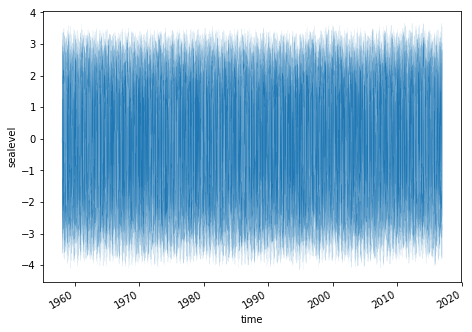

In [5]:
sealevel_ds = xr.open_dataset(files[-1])
sealevel_ds['sealevel'] = sealevel_ds['sealevel'] / 1000.0
sealevel_ds.sealevel.plot(linewidth=0.05, size=5)

sample_period = sealevel_ds
lon = sample_period.longitude.item()
lat = sample_period.latitude.item()

Loading ls5 pixel quality
    Loading 342 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 67 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 81 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


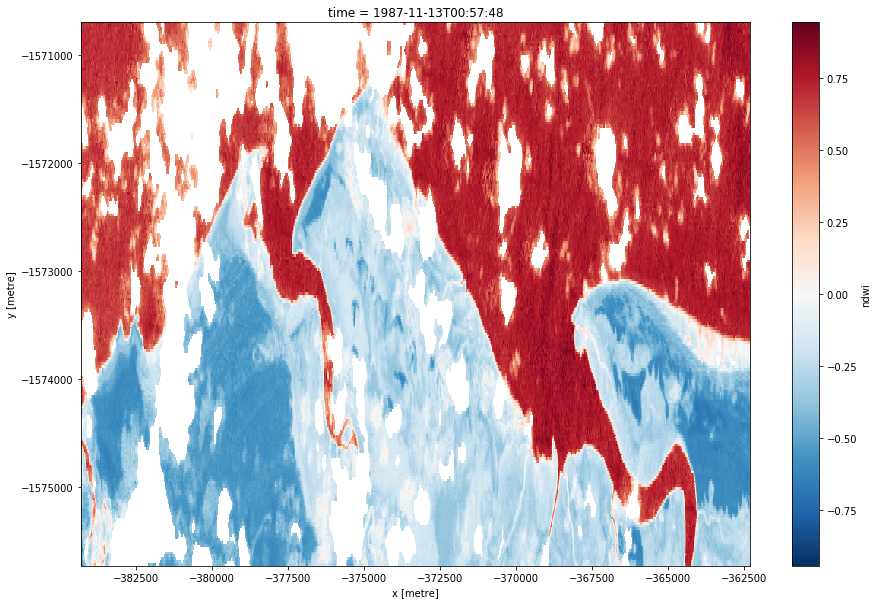

In [282]:
# Create datacube instance
dc = datacube.Datacube(app='Tidal tagging')

# Set up analysis data query
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - 11000, x + 11000),
         'y': (y - 3000, y + 2000),         
         'crs': 'EPSG:3577',
         'resolution': (-25, 25),
         'output_crs': 'EPSG:3577',
         'time': ('1986-06-01', '2016-12-31')}

# Load in only clear Landsat observations with < 1% unclear values
data = DEADataHandling.load_clearlandsat(dc=dc, query=query, 
                                       bands_of_interest=['red', 'green', 'blue', 'nir', 'swir1'], 
                                       masked_prop=0.0, mask_pixel_quality=True) 

# data['ndwi'] = (data.green - data.nir) / (data.green + data.nir)
data['ndwi'] = (data.green - data.swir1) / (data.green + data.swir1)
data.ndwi.isel(time = 5).plot(size=10)

## Test ITEM confidence for WA vs OTPS

In [283]:
# Calculate old tide heights
observed_datetimes = data.time.data.astype('M8[s]').astype('O').tolist()
observed_timepoints = [otps.TimePoint(lon, lat, dt) for dt in observed_datetimes]
observed_predictedtides = otps.predict_tide(observed_timepoints)
tideheights_old = [predictedtide.tide_m for predictedtide in observed_predictedtides]
data['tideheights_old'] = xr.DataArray(tideheights_old, [('time', data.time)])

# Calculate new tide heights
# tideheights_new = sealevel_ds.sel(time=observed_datetimes, method='nearest').sealevel.values.tolist()
tideheights_new = sealevel_ds.interp(time=observed_datetimes).sealevel.values.tolist()
data['tideheights_new'] = xr.DataArray(tideheights_new, [('time', data.time)])


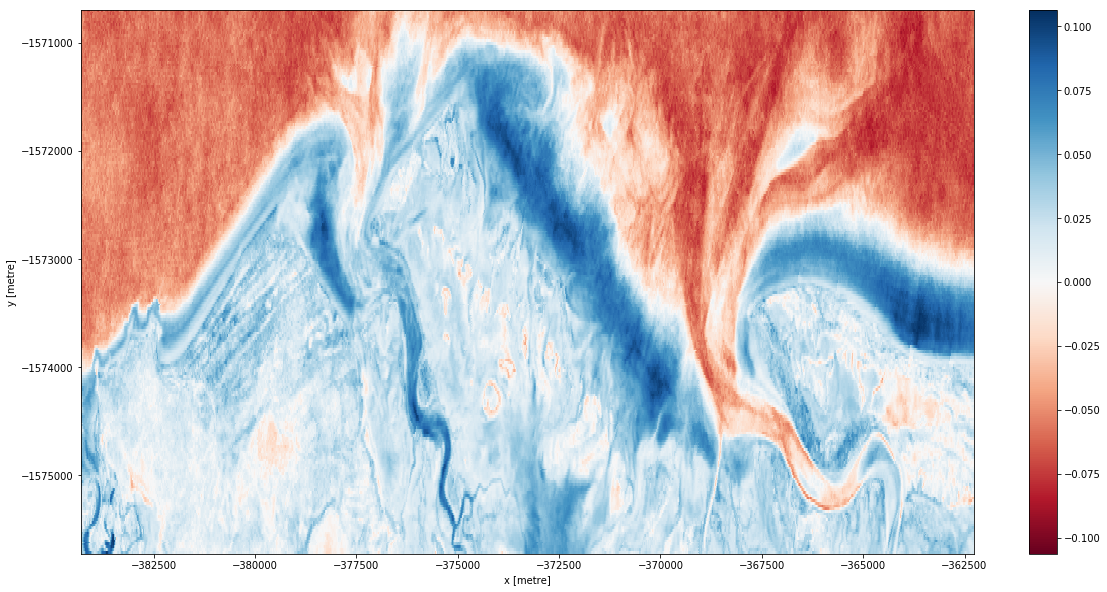

In [293]:
cov, cor_old, slope_old, intercept, pval_old, stderr_old = lag_linregress_3D(data['tideheights_old'], data['ndwi'], lagx=0, lagy=0, first_dim='time')
cov, cor_new, slope_new, intercept, pval_new, stderr_new = lag_linregress_3D(data['tideheights_new'], data['ndwi'], lagx=0, lagy=0, first_dim='time')
(cor_new - cor_old).plot(cmap='RdBu', size=10, aspect=2)

In [10]:
high_old = data.tideheights_old > data.tideheights_new.quantile(0.9)
high_new = data.tideheights_new > data.tideheights_new.quantile(0.9)

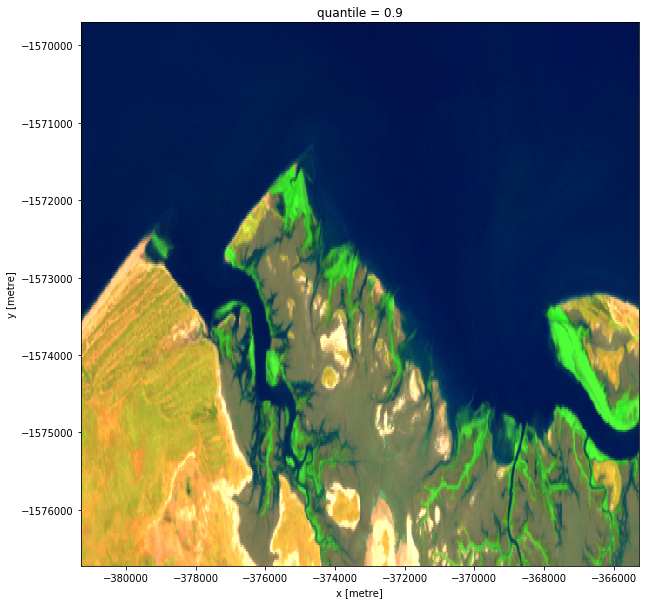

In [11]:
data.sel(time=high_old).median(dim='time')[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, size=10, aspect=1)

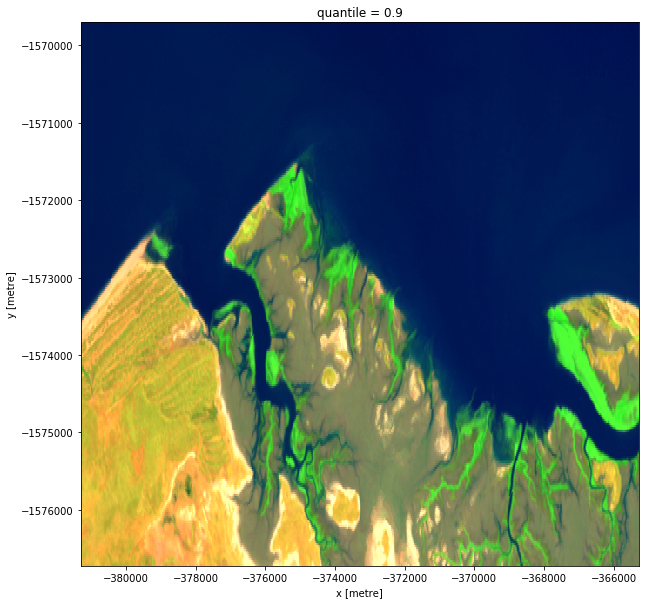

In [25]:
data.sel(time=high_new).median(dim='time')[['swir1', 'nir', 'green']].to_array().plot.imshow(robust=True, size=10, aspect=1)

15 6
32 31
42 40
57 60
62 65
63 52
63 47
71 79
59 67
26 43
Skip


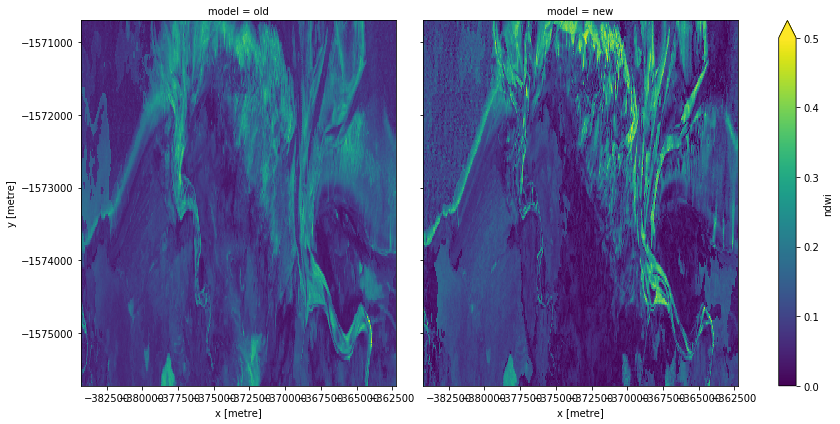

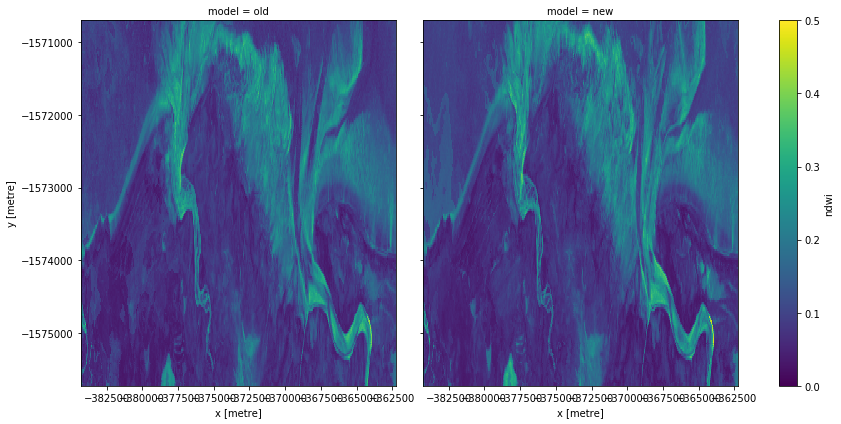

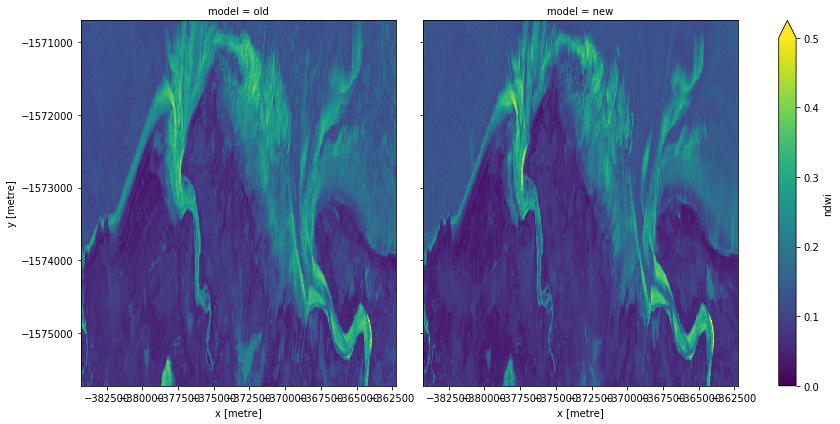

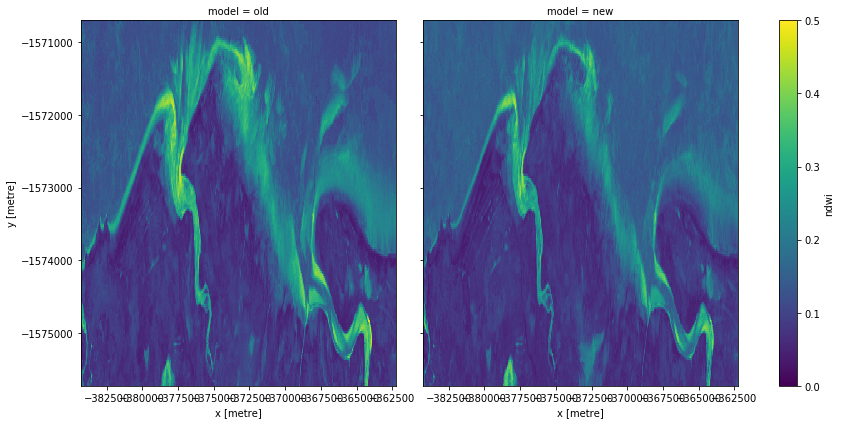

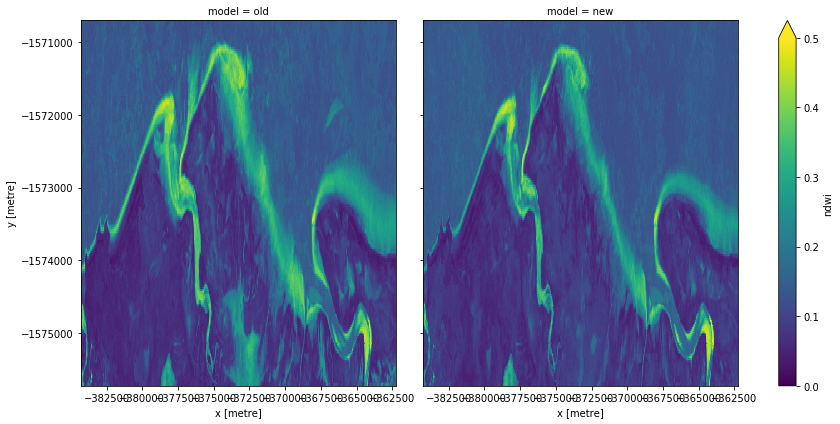

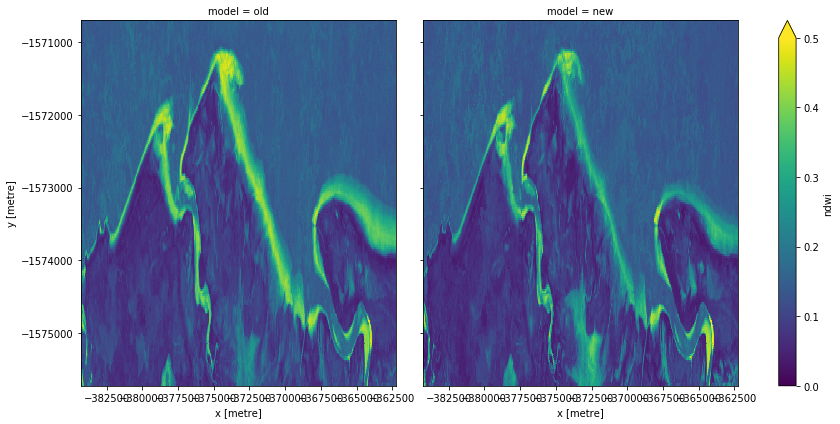

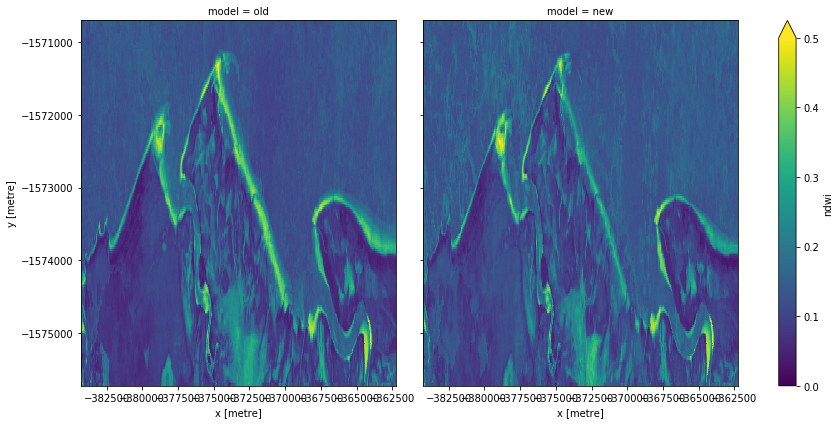

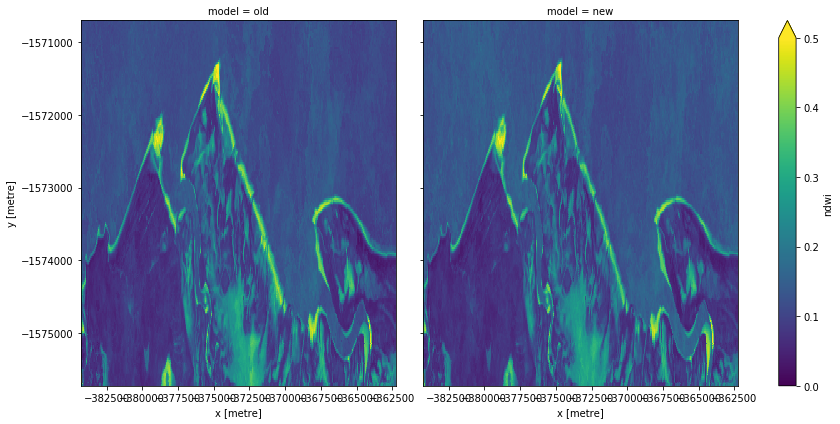

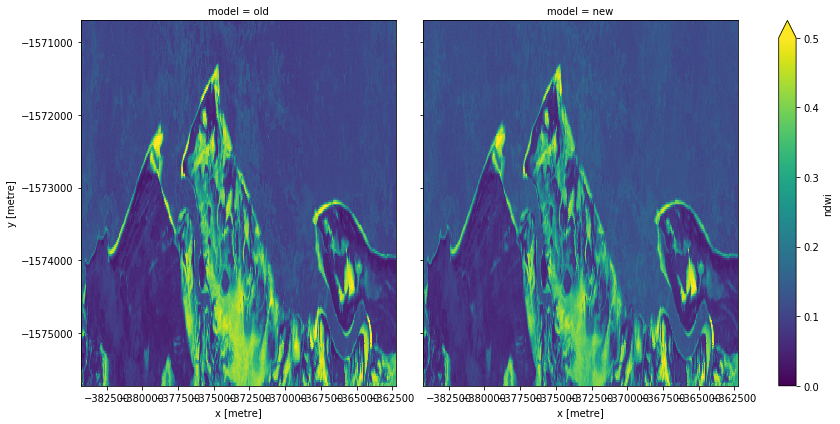

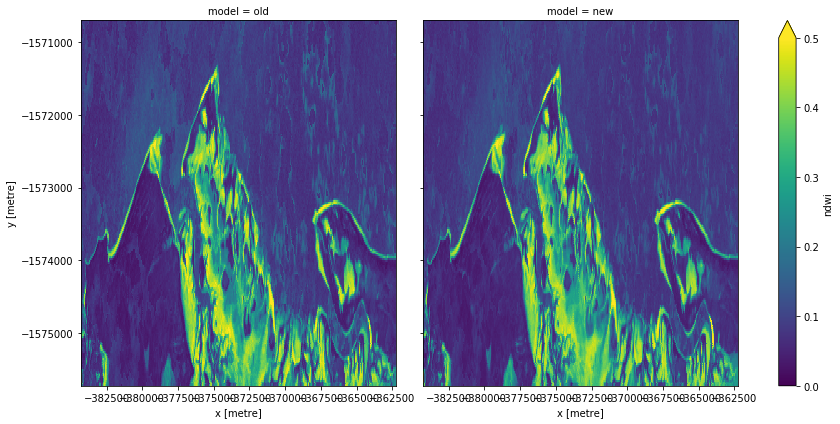

In [285]:
# import numpy as np
intervals = list(zip(np.linspace(data['tideheights_old'].min(), data['tideheights_old'].max(), 11),
                np.linspace(data['tideheights_new'].min(), data['tideheights_new'].max(), 11)))

out = []
out_ndwi = []

for i, (min_tide_old, min_tide_new) in enumerate(intervals):    
 
    try:
        
        max_tide_old, max_tide_new = intervals[i+1]
        old_subset = data.where((data.tideheights_old >= min_tide_old) & (data.tideheights_old <= max_tide_old), drop = True)
        new_subset = data.where((data.tideheights_new >= min_tide_new) & (data.tideheights_new <= max_tide_new), drop = True)
        print(len(old_subset.time), len(new_subset.time))

        if min_count > 1:

            model_comparison = xr.concat([old_subset.ndwi.std(dim = 'time'),
                                          new_subset.ndwi.std(dim = 'time')], 
                                          dim=xr.DataArray(['old', 'new'], dims='model', name='model'))  
            model_comparison.plot(col='model', size=6, aspect=1, vmin=0, vmax=0.5)
            out.append(model_comparison)
            
            model_comparison = xr.concat([old_subset.ndwi.median(dim = 'time'),
                                          new_subset.ndwi.median(dim = 'time')], 
                                          dim=xr.DataArray(['old', 'new'], dims='model', name='model'))              
            out_ndwi.append(model_comparison)
            
    except:
        print('Skip')
   


/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  if __name__ == '__main__':


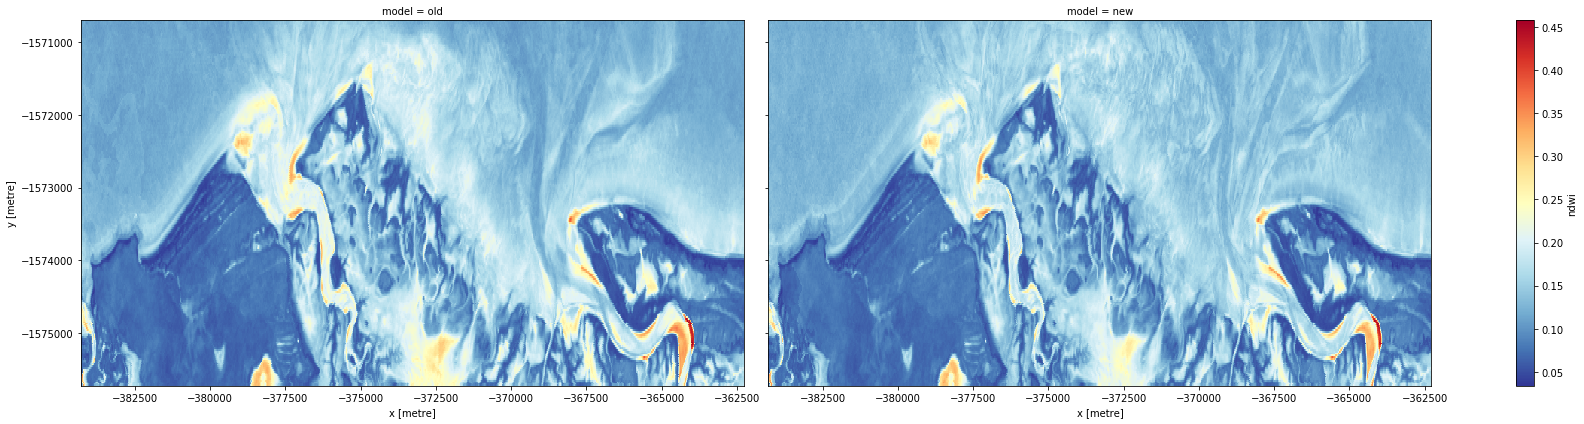

In [288]:
xr.concat(out).mean(dim='concat_dims').plot(col='model', size=6, aspect=2, cmap='RdYlBu_r')

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  if __name__ == '__main__':


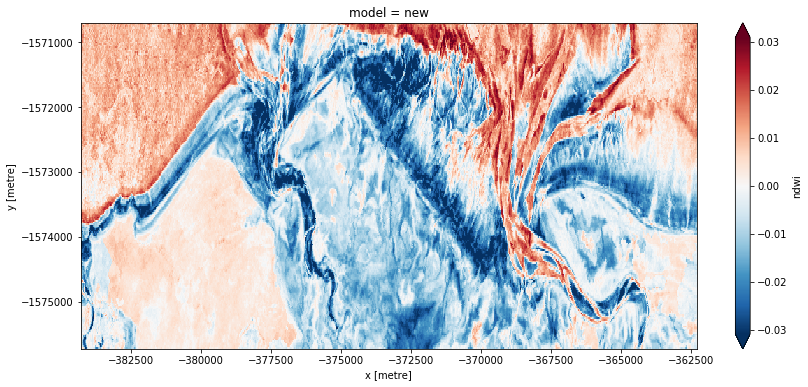

In [292]:
xr.concat(out).mean(dim='concat_dims').diff(dim='model').plot(size=6, aspect=2.3, robust=True)

In [273]:
xr.concat(out_ndwi)

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: the `dim` argument to `concat` will be required in a future version of xarray; for now, setting it to the old default of 'concat_dim'
  if __name__ == '__main__':


<xarray.DataArray 'ndwi' (concat_dims: 9, model: 2, y: 241, x: 241)>
array([[[[ 0.641264, ...,  0.568955],
         ...,
         [-0.20514 , ..., -0.26108 ]],

        [[ 0.703854, ...,  0.615036],
         ...,
         [-0.359773, ..., -0.358887]]],


       ...,


       [[[ 0.913312, ...,  0.90569 ],
         ...,
         [-0.194145, ..., -0.255607]],

        [[ 0.902779, ...,  0.895639],
         ...,
         [-0.204055, ..., -0.262116]]]])
Coordinates:
  * y        (y) float64 -1.57e+06 -1.57e+06 -1.57e+06 ... -1.576e+06 -1.576e+06
  * x        (x) float64 -3.763e+05 -3.763e+05 ... -3.703e+05 -3.703e+05
  * model    (model) <U3 'old' 'new'
Dimensions without coordinates: concat_dims

## Load WA sea level into xarray format

In [ ]:
# Open all data
all_nodes = xr.open_mfdataset(paths=files, concat_dim='file').squeeze('coast_id')

# Interpolate hourly results to get sea level estimates for exact acquisition time
all_nodes = all_nodes.interp(time=data.time.data.astype('M8[s]').astype('O').tolist())

# Select only required timesteps
all_nodes  = all_nodes[['time', 'id', 'node', 'latitude', 'longitude', 'sealevel']]

# Re-index to give latitude, longitude and time dimensions
test = all_nodes.set_index({'file': ['latitude', 'longitude']}).unstack()


In [ ]:
for i in range(0,len(test.time) - 1):
    
    # Import as a dataframe with lon, lat, time, sea level columns
    test_df_subset = test.isel(time=i).sealevel.to_dataframe().dropna(axis=0).reset_index() 

    from pyproj import Proj, transform
    xx, yy = transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), test_df_subset.longitude.values, test_df_subset.latitude.values)
    test_df_subset['Coordinates'] = list(zip(*transform(Proj(init='epsg:4326'), Proj(init='epsg:3577'), test_df_subset.longitude.values, test_df_subset.latitude.values)))

    # # Create geopandas dataframe by creating geometry column
    # test_df_subset['Coordinates'] = list(zip(test_df_subset.longitude, test_df_subset.latitude))
    test_df_subset['Coordinates'] = test_df_subset['Coordinates'].apply(Point)
    test_df_subset = gpd.GeoDataFrame(test_df_subset, geometry='Coordinates', crs='EPSG:3577')
    # # # test_gdf.to_file('test.shp')

    # Interpolate
    resolution = 500
    out = interp_tides(x_coords=test_df_subset['longitude'].values, 
                       y_coords=test_df_subset['latitude'].values, 
                       z_coords=test_df_subset[['sealevel']].values, 
                       sigma=15, resolution=resolution)


    # Create land sea mask from shapefile
    test_affine = rasterio.transform.from_bounds(west=xx.min(), 
                                                 south=yy.min(), 
                                                 east=xx.max(), 
                                                 north=yy.max(), width=out.shape[1], height=out.shape[0])

    coastline_mask = rasterio.features.geometry_mask(coastline_gpd.geometry,
                                                     out_shape=(resolution, resolution),
                                                     transform=test_affine,
                                                     all_touched=False, invert=True)
    
    print(np.min(out), np.max(out))

    # Remove land
    out[coastline_mask] = np.nan
#     out[out > 2500] = np.nan
#     out[out < 1500] = np.nan

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(20, 16))
    test_df_subset.plot(column='sealevel', ax=ax[0])
    im = ax[1].imshow(out, extent=[upleft_x, bottomright_x, bottomright_y, upleft_y], vmin=-2000, vmax=3000)
    # fig.colorbar(im)

